<a href="https://colab.research.google.com/github/malekzitouni/Generative-AI-with-diffusion-Models/blob/main/Denoising_Diffusion_Probabilistic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goals of this notebook are to:
* Construct a forward diffusion variance schedule
* Define the forward diffusion function, `q`
* Update the U-Net architecture to accommodate a timestep, `t`
* Train a model to detect noise added to an image based on the timestep `t`
* Define a reverse diffusion function to emulate `p`
* Attempt to generate articles of clothing (again)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from IPython.display import Image

# User defined libraries
from utils import other_utils

IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 6.21MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 59.7MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.51MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
nrows = 5
ncols = 10

T = nrows * ncols
start = 0.0001
end = 0.03
B = torch.linspace(start, end, T).to(device)
B
# the step between values are step=(end-start)/(T-1)

tensor([1.0000e-04, 7.1020e-04, 1.3204e-03, 1.9306e-03, 2.5408e-03, 3.1510e-03,
        3.7612e-03, 4.3714e-03, 4.9816e-03, 5.5918e-03, 6.2020e-03, 6.8122e-03,
        7.4224e-03, 8.0327e-03, 8.6429e-03, 9.2531e-03, 9.8633e-03, 1.0473e-02,
        1.1084e-02, 1.1694e-02, 1.2304e-02, 1.2914e-02, 1.3524e-02, 1.4135e-02,
        1.4745e-02, 1.5355e-02, 1.5965e-02, 1.6576e-02, 1.7186e-02, 1.7796e-02,
        1.8406e-02, 1.9016e-02, 1.9627e-02, 2.0237e-02, 2.0847e-02, 2.1457e-02,
        2.2067e-02, 2.2678e-02, 2.3288e-02, 2.3898e-02, 2.4508e-02, 2.5118e-02,
        2.5729e-02, 2.6339e-02, 2.6949e-02, 2.7559e-02, 2.8169e-02, 2.8780e-02,
        2.9390e-02, 3.0000e-02])

A [Normal Dsitribution](https://mathworld.wolfram.com/NormalDistribution.html) has the following signature:

$\mathcal{N}(x;u,\sigma^2)$ = $\frac{1}{\sigma\sqrt{2\pi}}\mathcal{e}^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}$

which reads as, "the normal distribution of $x$ with parameters $u$ (the mean) and $\sigma^2$ (the variance). When $\mu$ is 0 amd $\sigma$ is 1, we have a standard normal distribution $\mathcal{N}(x;0,1)$, which has the probability density of the shape below:

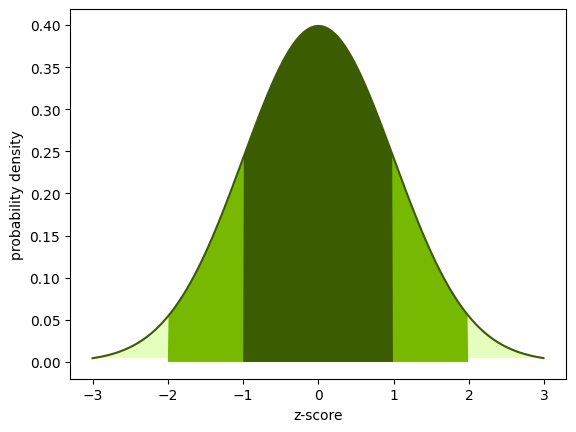


If we are altering our image with noise multiple times accross many timesteps, let's describe $\mathbf{x}_{t}$ as our image at timestep $t$. Then, $\mathbf{x}_{t-1}$ would be the image at the previous timestep and $x_{0}$ would be the original image.

In the previous notebook, we added noise to images using the equation:

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1})=\mathcal{N}(\mathbf{x}_{t};(1-\beta_{t}) \cdot \mathbf{x}_{t-1},\beta_{t}^{2}  \cdot \mathbf{I})$

Where $q$ represents a probability distribution for the [forward diffusion process](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#forward-diffusion-process) and $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$ describes the probability distribution for a new, noiser image $\mathbf{x}_{t}$ based on $\mathbf{x}_{t-1}$.

This time, we will alter images with the similar equation:

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1})=\mathcal{N}(\mathbf{x}_{t};\sqrt{1-\beta_{t}} \cdot \mathbf{x}_{t-1},\beta_{t} \cdot \mathbf{I})$

We can sample from this probability distribution by first sampling from a standard normal distribution $\mathcal{N}(x;0,1)$ using [torch.randn_like](https://pytorch.org/docs/stable/generated/torch.randn_like.html):

`noise = torch.randn_like(x_t)`

We can then multiply and add to the noise to sample from `q`:

`x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise`

Let's see all of this in practice. Run the code cell below to perform forward diffusion `T` (or `150`) times on the first image of our dataset.


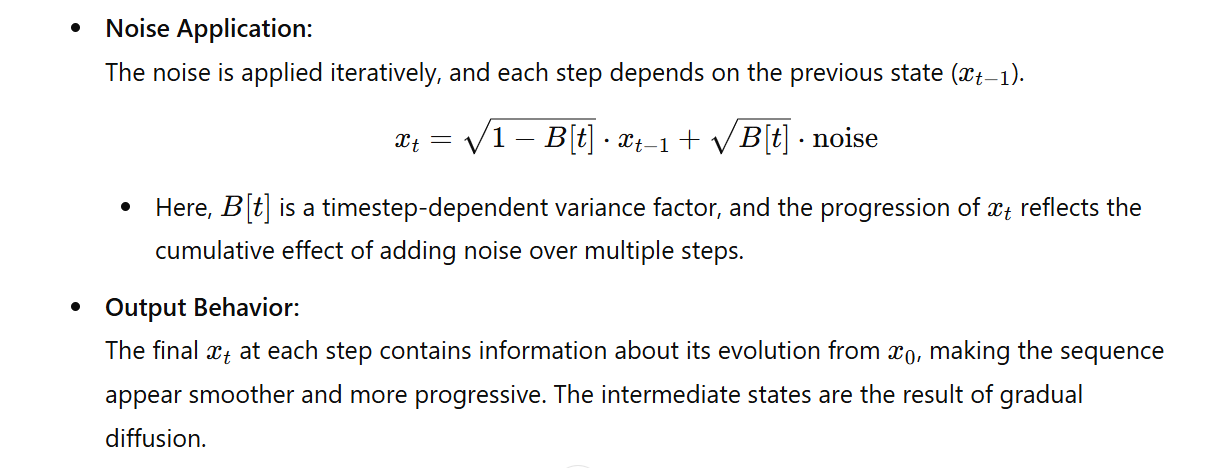

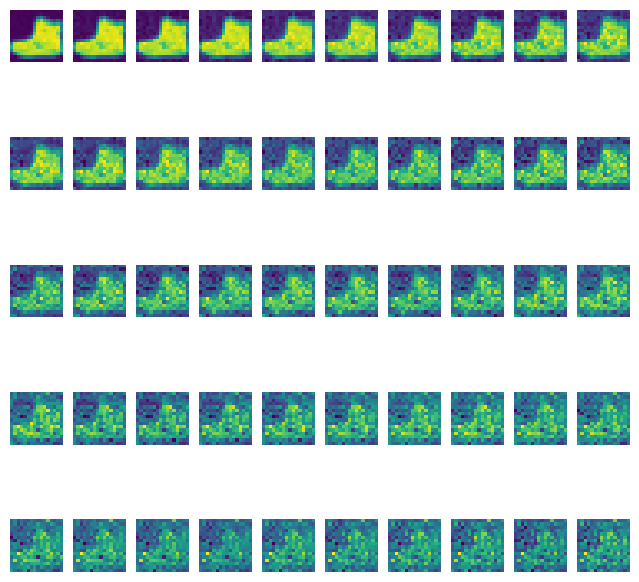

In [ ]:
plt.figure(figsize=(8, 8))
x_0 = data[0][0].to(device)  # Initial image
x_t = x_0  # Set up recursion
xs = []  # Store x_t for each T to see change"


for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise  # sample from q(x_t|x_t-1)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis("off")
    plt.imshow(img)
plt.savefig("forward_diffusion.png", bbox_inches="tight")

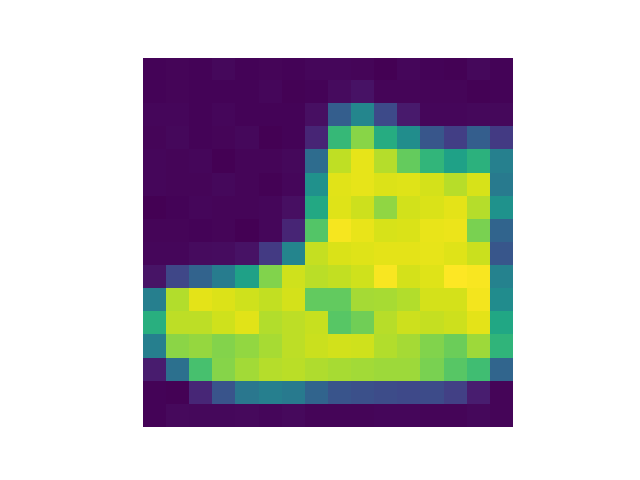

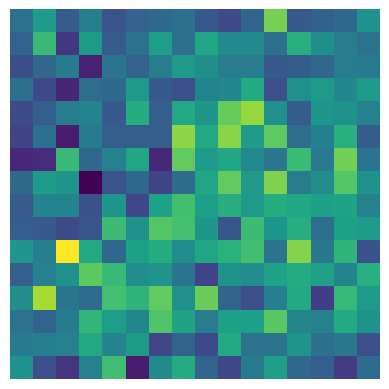

In [ ]:
gif_name = "forward_diffusion.gif"
other_utils.save_animation(xs, gif_name)
Image(open(gif_name,'rb').read())

We could take each image of our dataset and add noise to them `T` times to create `T` more new images, but do we need to?

Thanks to the power of recursion, we can estimate what $x_t$ would look like given our beta schedule $\beta_t$. A full breakdown of the math can be found in [Lilian Weng's Blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#speed-up-diffusion-model-sampling).
Let's bring back `a`lpha, which is the compliment of $\beta$. We can define $\alpha_t$ as $1 - \beta_t$, and we can define $\bar{\alpha}_t$ as the [cumulative product](https://pytorch.org/docs/stable/generated/torch.cumprod.html) of $\alpha_t$.

For example, $\bar{\alpha}_3 = \alpha_0 \cdot \alpha_1 \cdot \alpha_2 \cdot \alpha_3$

Because of the bar symbol, let's call $\bar{\alpha}_t$ `a_bar`. Our new noisy image distribution becomes:

$q(\mathbf{x}_{t}|\mathbf{x}_{0})=\mathcal{N}(\mathbf{x}_{t};\sqrt{\bar{\alpha}_{t}} \cdot x_{0},(1 - \bar{\alpha}_t) \cdot \mathbf{I})$

Which translates to code as:

`x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise`

We are now no longer dependent on $\mathbf{x}_{t-1}$ and can estimate $\mathbf{x}_t$ from $x_0$. Let's define these variables in code:

In [ ]:
a = 1. - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar) # St. Dev. Coefficient
a_bar

tensor([0.9999, 0.9992, 0.9979, 0.9959, 0.9934, 0.9903, 0.9866, 0.9822, 0.9774,
        0.9719, 0.9659, 0.9593, 0.9522, 0.9445, 0.9363, 0.9277, 0.9185, 0.9089,
        0.8988, 0.8883, 0.8774, 0.8661, 0.8544, 0.8423, 0.8299, 0.8171, 0.8041,
        0.7907, 0.7772, 0.7633, 0.7493, 0.7350, 0.7206, 0.7060, 0.6913, 0.6765,
        0.6615, 0.6465, 0.6315, 0.6164, 0.6013, 0.5862, 0.5711, 0.5561, 0.5411,
        0.5262, 0.5113, 0.4966, 0.4820, 0.4676])

In [ ]:

def q(x_0, t):
    """
    Samples a new image from q
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

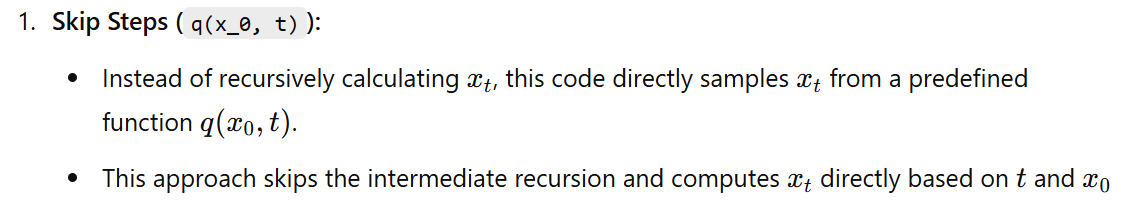

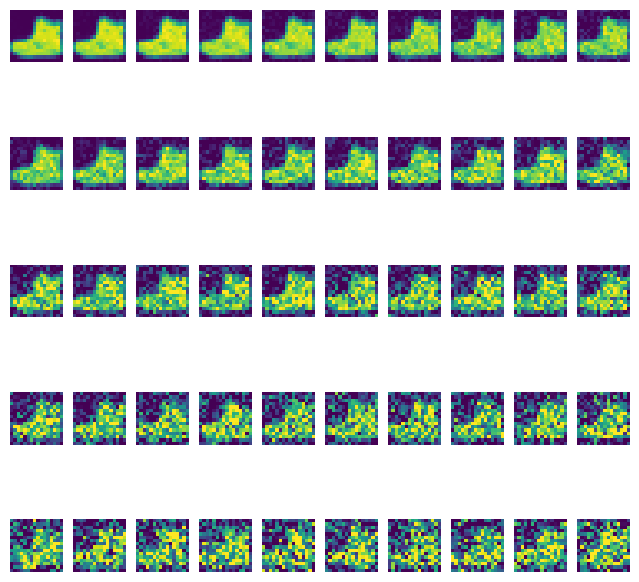

In [ ]:
plt.figure(figsize=(8, 8))
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    other_utils.show_tensor_image(x_t)
plt.savefig("forward_diffusion_skip.png", bbox_inches='tight')

Each
𝑥
𝑡 is a snapshot of the diffusion process at a specific
𝑡, computed independently.

-Each
𝑥
𝑡 is computed directly without reference to prior states.

### Comparison of Two Diffusion Approaches

#### **1. Recursive Diffusion Approach (First Code):**
- **Computation:**
  - Computes \( x_t \) iteratively from \( x_{t-1} \) using:
      - Noise builds up incrementally across timesteps.
- **Output Characteristics:**
  - Produces a smooth, progressive sequence of images.
  - Each image reflects the gradual degradation of \( x_0 \) over time.

#### **2. Direct Sampling Approach with `q(x_0, t)` (Second Code):**
- **Computation:**
  - Directly samples \( x_t \) from \( x_0 \) for a given \( t \) using:

  - Each \( x_t \) is computed independently without reference to prior states.
- **Output Characteristics:**
  - Produces discrete, non-progressive snapshots of \( x_t \).
  - Transitions between timesteps may appear less smooth or correlated.

#### **Key Difference:**
- The **recursive approach** emphasizes continuity and smooth evolution of the diffusion process, while the **direct sampling approach** is more efficient but lacks temporal coherence between steps.


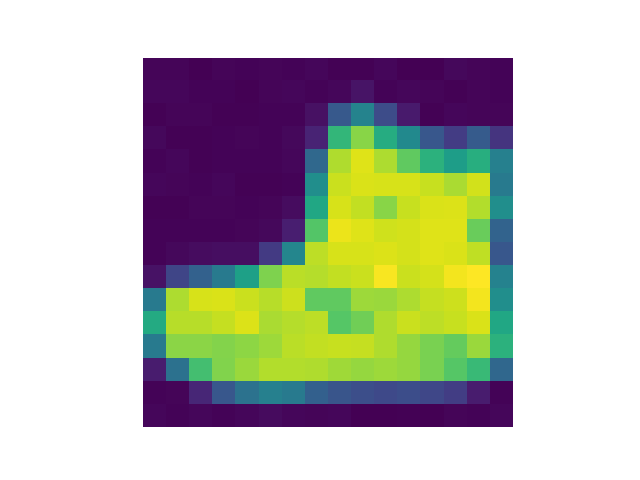

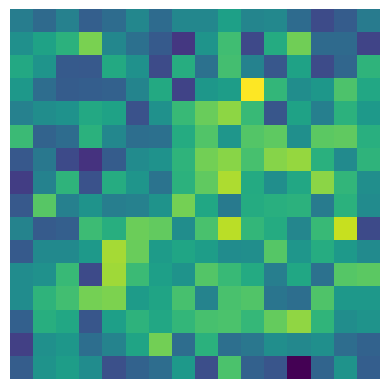

In [ ]:
gif_name = "forward_diffusion_skip.gif"
other_utils.save_animation(xs, gif_name)
Image(open(gif_name,'rb').read())

The neural network needs to know which timestep (\( t \)) an input image corresponds to because the level of noise in the diffusion process depends on \( t \). To achieve this, we use a **time embedding block** that converts the scalar \( t \) into a format compatible with the network's multidimensional feature maps. Here's an explanation of the components and their roles:

---

### **Key Components of the Time Embedding Block:**

1. **`input_dim`:**
   - Represents the number of dimensions in the input to the embedding block.
   - Since \( t \) is a single scalar value (1-dimensional),input_dim = 1).

2. **`emb_dim`:**
   - Represents the number of dimensions the embedding block will convert \( t \) into.
   - A higher-dimensional representation allows the network to better capture and utilize the information about the timestep.

3. **[Linear Layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html):**
   - A fully connected layer that transforms \( t \) from its input dimension (`input_dim`) to the desired embedding dimension (`emb_dim`).
   - It learns weights to effectively represent \( t \) in the higher-dimensional space.

4. **[UnFlatten Layer](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html):**
   - Reshapes the output of the embedding (a 1D vector) into a multidimensional tensor.
   - This is necessary because the embedding will be added to the feature maps produced by the neural network, which have multiple dimensions (e.g., channels, height, width).
   - For instance, if the embedding output is \( [\text{batch\_size}, \text{emb\_dim}] \), the `UnFlatten` layer might reshape it into \( [\text{batch\_size}, \text{emb\_dim}, 1, 1] \), making it compatible with the network's feature maps.

---

### **Purpose of Time Embedding:**
- Encodes information about the timestep \( t \) into a high-dimensional space, allowing the network to:
  - Adapt its behavior depending on the noise level at \( t \).
  - Generate outputs that are conditioned on the specific diffusion step.
- The reshaped embedding (via `UnFlatten`) aligns with the spatial dimensions of the network's intermediate feature maps, enabling seamless addition.

---

### **Why This Matters:**
- Noise changes dynamically across timesteps in the forward diffusion process. Without timestep awareness, the neural network cannot properly denoise or handle the input image.
- The embedding ensures that \( t \) information is integrated into the network’s processing pipeline, allowing it to learn timestep-specific patterns and transformations.

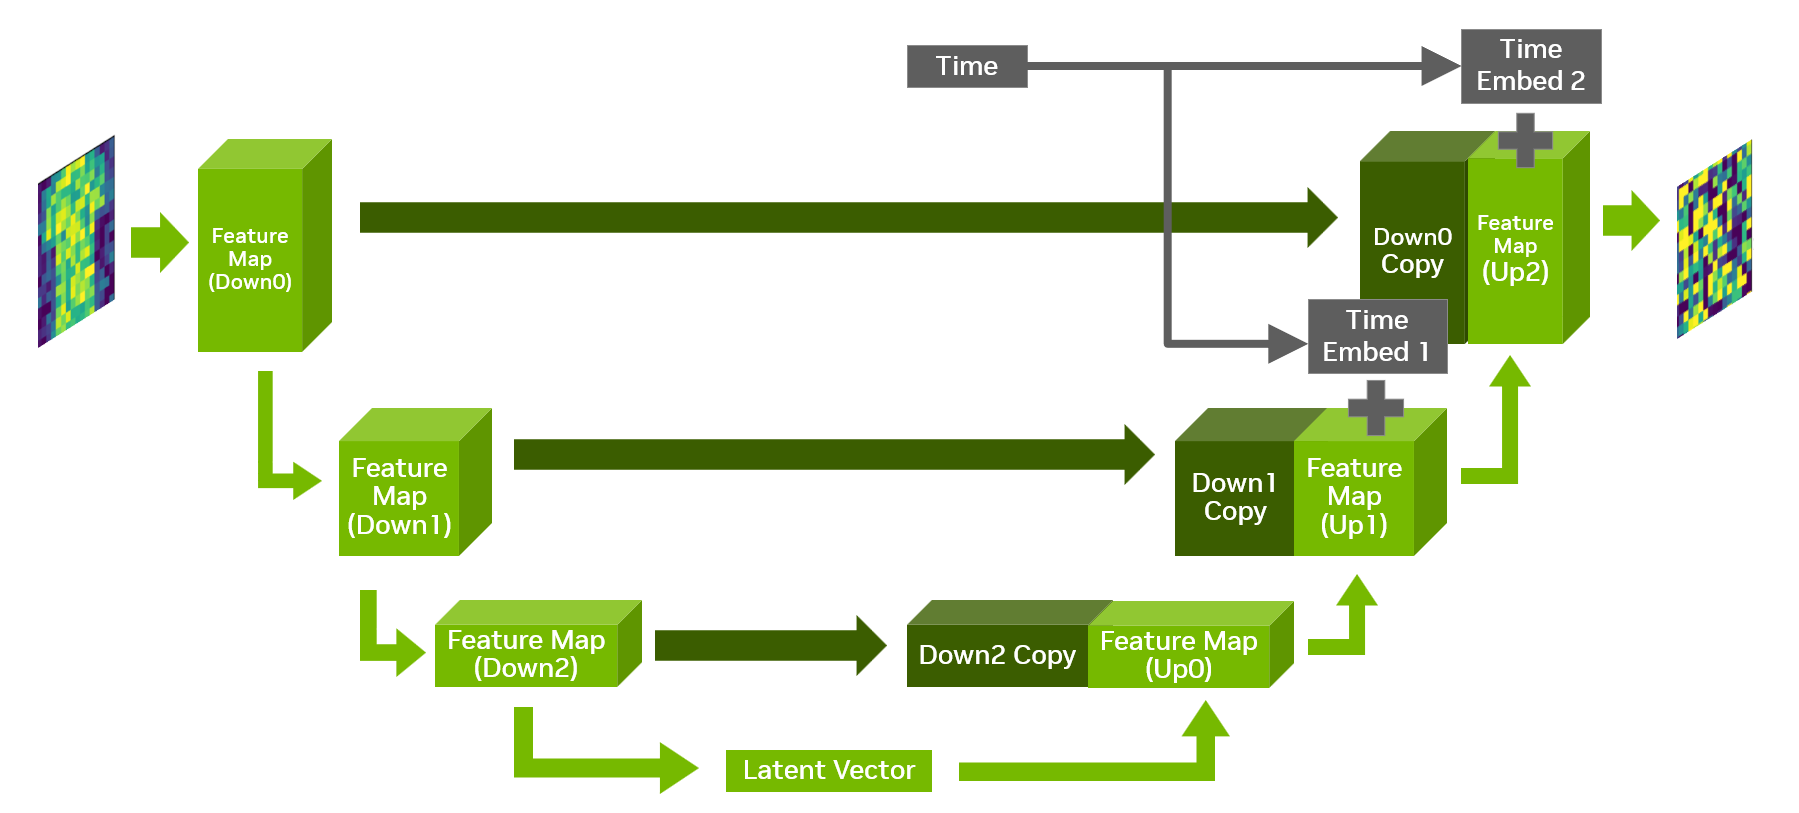

In [ ]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),#Applies an affine linear transformation to the incoming data
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.input_dim)
        return self.model(input)

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])  # New
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])  # New

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        latent_vec = self.dense_emb(latent_vec)
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

In [ ]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(UNet().to(device))

Num params:  240385


In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

We now have a model that predicts the noise added to an image at timestep `t`, but generating images is not as easy as repeatedly subtracting and adding noise. The `q` function can be reversed such that we generate $\mathbf{x}_(t-1)$ from $\mathbf{x}_t$.

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t-1};{\mathbf{\tilde{\mu}}}(\mathbf{x_t},\mathbf{x_0}), \tilde{\beta}_t \cdot \mathbf{I})$

**Note**: $\tilde{\beta}_t$ was originally calculated to be $\frac{1-\overline{a}_{t-1}}{1-\overline{a}_{t}}\beta_t$, but in practice, using only $\beta_t$ is more effective.

Using [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), we can derive an equation for the model_mean `u_t` at timestep `t`.

${\mathbf{\tilde{\mu}}}_t = \frac{1}{\sqrt{\alpha_t}}(\mathbf{x_t}-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha_t}}}\mathbf{\epsilon}_t)$

The image $\mathbf{x}_{t-1}$ can be estimated by ${\mathbf{\tilde{\mu}}}_t + \tilde{\beta}_t \cdot \mathbf{I}$, so we'll use this equation to generate sample images recursively until we reach `t == 0`. Let's see what this means in code. First, we will precompute the values needed to calculate `u_t`.

In [ ]:
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)

In [ ]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [ ]:
@torch.no_grad()
def sample_images(ncols, figsize=(12, 12)):
    """
    Generates and visualizes images using the reverse diffusion process.

    Args:
        ncols (int): Number of columns for the subplot grid.
        figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)

    # Adjust spacing for better visualization
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce space between subplots

    # Calculate how often to plot based on the number of timesteps
    hidden_rows = int(T / ncols)

    # Initialize random noise
    x_t = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)

    plot_number = 1  # Tracks subplot index
    for i in range(T - 1, -1, -1):  # Loop from T-1 to 0
        t = torch.full((1,), i, device=device)  # Current timestep as tensor
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)  # Reverse diffusion step

        # Plot image at selected timesteps
        if i % hidden_rows == 0 and plot_number <= ncols:
            ax = plt.subplot(1, ncols, plot_number)  # Create subplot
            ax.axis('off')  # Hide axes
            other_utils.show_tensor_image(x_t.detach().cpu())  # Display image
            plot_number += 1

    plt.show()


Epoch 0 | Step 000 | Loss: 0.18642295897006989 


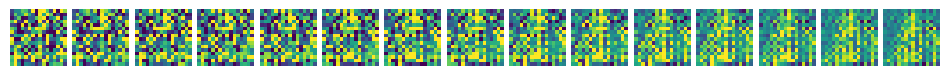

Epoch 0 | Step 100 | Loss: 0.17940208315849304 


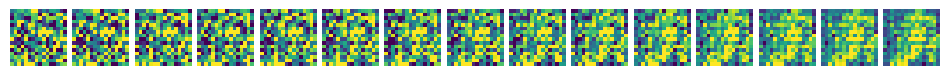

Epoch 0 | Step 200 | Loss: 0.1901153177022934 


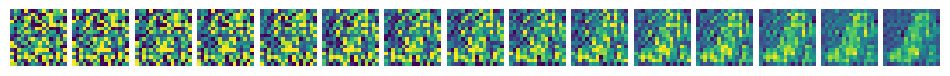

Epoch 0 | Step 300 | Loss: 0.2134619802236557 


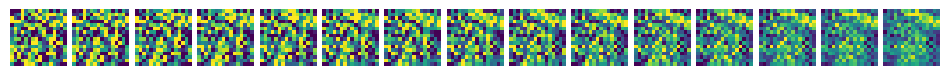

Epoch 0 | Step 400 | Loss: 0.19649356603622437 


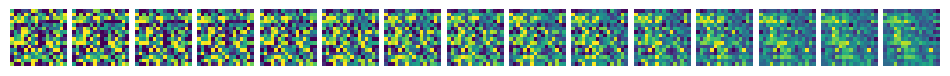

Epoch 0 | Step 500 | Loss: 0.17814403772354126 


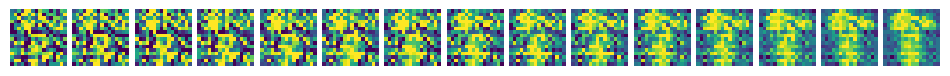

Epoch 1 | Step 000 | Loss: 0.18184833228588104 


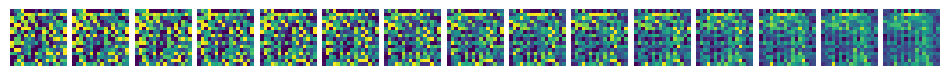

Epoch 1 | Step 100 | Loss: 0.1815362423658371 


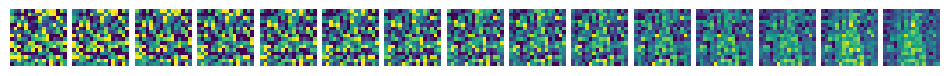

Epoch 1 | Step 200 | Loss: 0.1923607438802719 


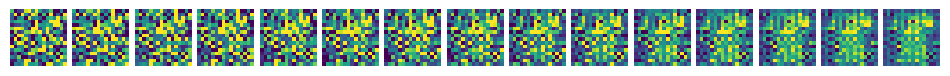

Epoch 1 | Step 300 | Loss: 0.1892983466386795 


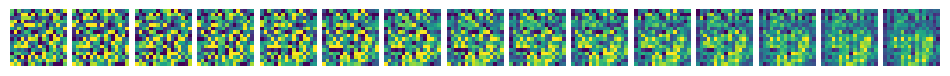

Epoch 1 | Step 400 | Loss: 0.196823388338089 


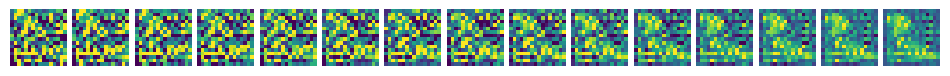

Epoch 1 | Step 500 | Loss: 0.20309045910835266 


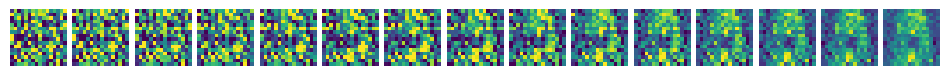

Epoch 2 | Step 000 | Loss: 0.18549734354019165 


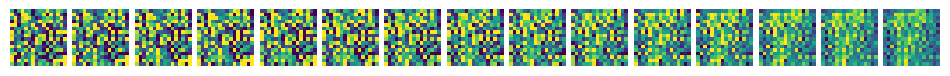

Epoch 2 | Step 100 | Loss: 0.19070786237716675 


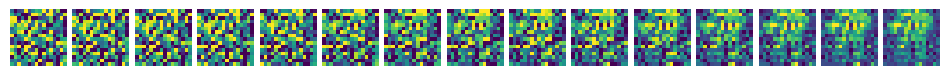

Epoch 2 | Step 200 | Loss: 0.18588784337043762 


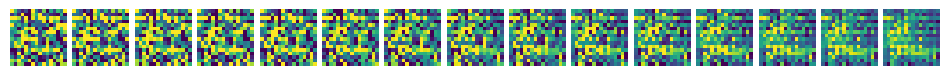

Epoch 2 | Step 300 | Loss: 0.17102903127670288 


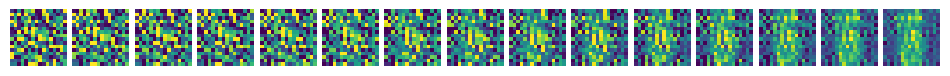

Epoch 2 | Step 400 | Loss: 0.1985083520412445 


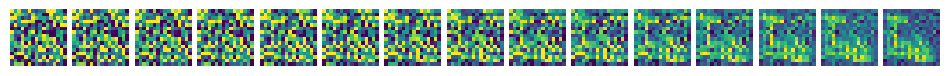

Epoch 2 | Step 500 | Loss: 0.16713257133960724 


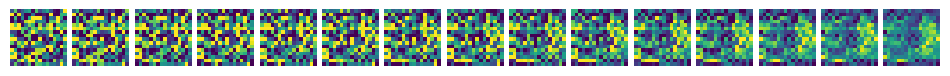

Final sample:


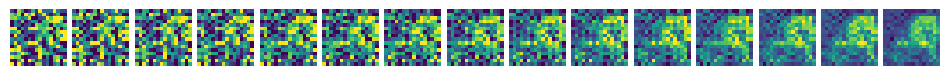

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
ncols = 15  # Should evenly divide T

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        x = batch[0].to(device)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
            sample_images(ncols)
print("Final sample:")
sample_images(ncols)

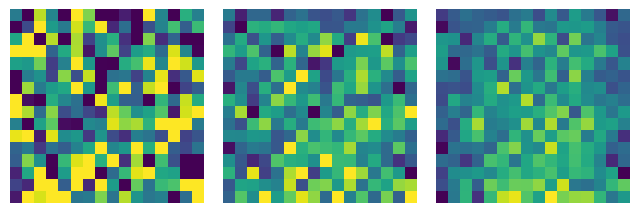

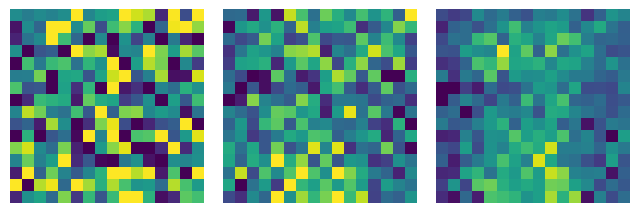

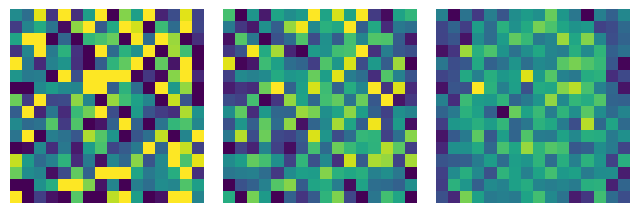

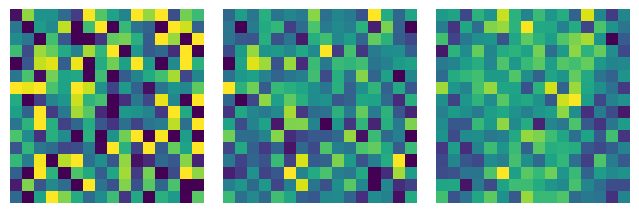

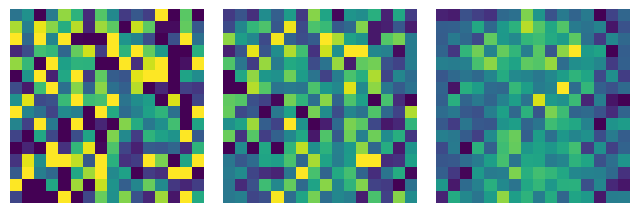

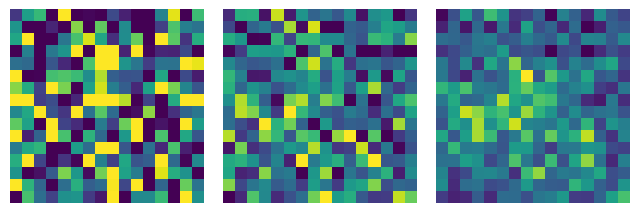

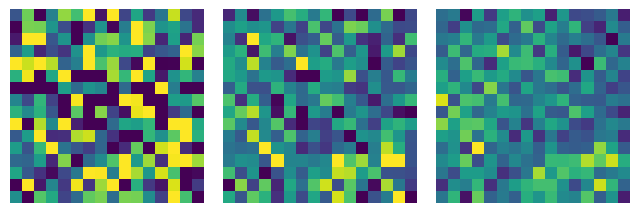

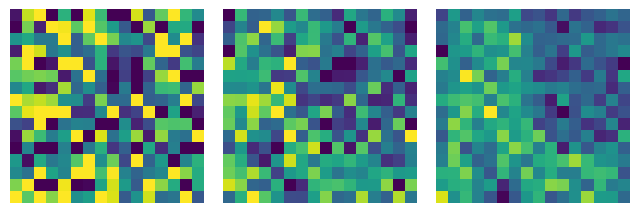

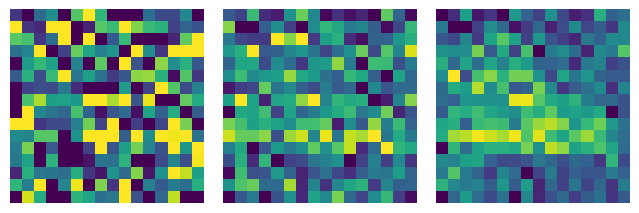

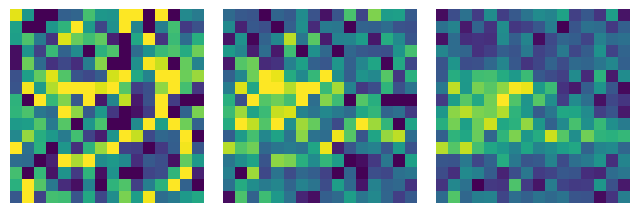

In [ ]:
model.eval()
figsize=(8,8) # Change me
ncols = 3 # Should evenly divide T
for _ in range(10):
    sample_images(ncols, figsize=figsize)